In [1]:
import sys, os

sys.path.append('../input/hubmap-submit-08') 
sys.path.append('../input/hubmap-submit-08/[third_party]')


from kaggle_hubmap_kv4 import * 
import importlib 
from timeit import default_timer as timer

import torch 
import torch.cuda.amp as amp 
import torch.nn.functional as F 
print('import ok\n')

#-- configure --------------------------------------------- 
#image_size = 768 #512

organ_threshold = { 
    'Hubmap': { 
        'kidney' : 0.28, 
        'prostate' : 0.28, 
        'largeintestine': 0.28, 
        'spleen' : 0.28, 
        'lung' : 0.10, 
    }, 
    'HPA': { 
        'kidney' : 0.50, 
        'prostate' : 0.50, 
        'largeintestine': 0.50, 
        'spleen' : 0.50, 
        'lung' : 0.10, 
    }, 
}

data_source = ['Hubmap', 'HPA'] 
organ = ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']

#data_source =['Hubmap',] 
#organ = ['spleen']

#submit_type = 'local-cv'
submit_type = 'kaggle'


import ok



In [2]:

## model ##################################
from daformer import * 
from smp_unet import *

from timm.models.efficientnet import tf_efficientnet_b6
from timm.models.convnext import convnext_large_384_in22ft1k

from coat import coat_parallel_small_level5 
from pvt_v2 import pvt_v2_b4, pvt_v2_b4_level5 
from dualvit import *
 

model = [ 
    dotdict( #[1]
        is_use=1,
        image_size=1024,
        module='model_pvt_v2_daformer',
        param={'encoder': pvt_v2_b4_level5, 'decoder': daformer_conv3x3, },
        checkpoint=[
            '../input/hubmap-submit-06-weight0/pvt_v2_b4_level5-daformer_conv3x3-aug5b-1024-fold-3-swa.pth',
            '../input/hubmap-submit-06-weight0/pvt_v2_b4_level5-daformer_conv3x3-aug5b-1024-fold-2-swa.pth', 
            '../input/hubmap-submit-06-weight0/pvt_v2_b4_level5-daformer_conv3x3-aug5b-1024-fold-1-swa.pth',
            
            #'../input/hubmap-submit-06-weight0/pvt_v2_b4_level5-daformer_conv3x3-aug5b-1024-fold-4-swa.pth',
             
        ],
    ),
    dotdict(#[2]
        is_use = 1,
        image_size = 1536,
        module = 'model_coat_daformer',
        param={'encoder': coat_parallel_small_level5, 'decoder':daformer_conv1x1},
        checkpoint = [ 
            '../input/hubmap-submit-06-weight0/coat_parallel_small_level5-daformer_conv1x1-aug8b-1536-fold-3-swa.pth',
            '../input/hubmap-submit-06-weight0/coat_parallel_small_level5-daformer_conv1x1-aug8b-1536-fold-2-swa.pth', 
            '../input/hubmap-submit-06-weight0/coat_parallel_small_level5-daformer_conv1x1-aug8b-1536-fold-1-swa.pth',
            
            #'../input/hubmap-submit-06-weight0/coat_parallel_small_level5-daformer_conv1x1-aug8b-1536-fold-4-swa.pth', 
            #'../input/hubmap-submit-06-weight0/coat_parallel_small_level5-daformer_conv1x1-aug8b-1536-fold-0-swa.pth',  
            '../input/hubmap-submit-06-weight1/coat_parallel_small_level5-daformer_conv1x1-aug8b-diff-seed-1536-fold-1-best-swa.pth', #0.80
            '../input/hubmap-submit-06-weight1/coat_parallel_small_level5-daformer_conv1x1-aug8b-diff-seed-1536-fold-4-best-swa.pth',#0.80
        
        ],
    ),
 
    
    dotdict( #[3]
        is_use=1,
        image_size=1536,
        module='model_effnet_smp_unet',
        param={'encoder': tf_efficientnet_b6, 'decoder': smp_unet},  
        checkpoint=[
            '../input/hubmap-submit-06-weight0/tf_efficientnet_b6-unet-aug8b-1536-fold-3-swa.pth', 
            '../input/hubmap-submit-06-weight0/tf_efficientnet_b6-unet-aug8b-1536-fold-2-swa.pth',
            '../input/hubmap-submit-06-weight0/tf_efficientnet_b6-unet-aug8b-1536-fold-1-swa.pth',
        ],
    ),
    dotdict(#[4]
        is_use = 1,
        image_size = 768,
        module = 'model_dualvit_daformer',
        param={'encoder': dual_vit_b, 'decoder':daformer_conv3x3},
        checkpoint = [
             '../input/hubmap-submit-06-weight0/dual_vit_b-daformer_conv3x3-aug8-768-fold-3-swa.pth',
             '../input/hubmap-submit-06-weight0/dual_vit_b-daformer_conv3x3-aug8-768-fold-2-swa.pth', 
             '../input/hubmap-submit-06-weight0/dual_vit_b-daformer_conv3x3-aug8-768-fold-1-swa.pth',
             
             #'../input/hubmap-submit-06-weight0/dual_vit_b-daformer_conv3x3-aug8-768-fold-4-swa.pth',
        ],
    ), 

    
    dotdict(#[5]
        is_use=1,
        image_size=1280,
        module='model_convnext_smp_unet',
        param={'encoder': convnext_large_384_in22ft1k, 'decoder': smp_unet},   
        checkpoint=[
            '../input/hubmap-submit-06-weight0/convnext_large_384_in22ft1k-smp_unet-aug8b-1280-fold-3-swa.pth',
            '../input/hubmap-submit-06-weight0/convnext_large_384_in22ft1k-smp_unet-aug8b-1280-fold-2-swa.pth',
            '../input/hubmap-submit-06-weight0/convnext_large_384_in22ft1k-smp_unet-aug8b-1280-fold-1-swa.pth',
            
            #'../input/hubmap-submit-06-weight0/convnext_large_384_in22ft1k-smp_unet-aug8b-1280-fold-4-swa.pth',
        ],
    ), 
    
    
#     dotdict(
#         is_use=0,  # 0,#1,
#         image_size=768,
#         module='model_pvt_v2_smp_unet',
#         param={'encoder': pvt_v2_b4, 'decoder': None},
#         checkpoint=[
#             '../input/hubmap-submit-06-weight0/pvt_v2_b4-smp_unet-aug8b-768-fold-3-swa.pth',

#         ],
#     ),
 
      dotdict(
        is_use=1,
        image_size=768,
        module='model_pvt_v2_daformer',
        param={'encoder': pvt_v2_b4, 'decoder': daformer_conv3x3},   
        checkpoint=[
            #'../input/hubmap-submit-06-weight1/pvt_v2_b4-aug8b-768-different-seed-fold-0-swa.pth', #lb=0.78
            #'../input/hubmap-submit-06-weight1/pvt_v2_b4-aug8b-768-different-seed-fold-2-swa.pth', #0.79 
            #'../input/hubmap-submit-06-weight1/pvt_v2_b4-aug8b-768-different-seed-fold-3-swa.pth',  #0.75
            '../input/hubmap-submit-06-weight1/pvt_v2_b4-aug8b-768-different-seed-fold-1-swa.pth', #0.80
            '../input/hubmap-submit-06-weight1/pvt_v2_b4-aug8b-768-different-seed-fold-4-swa.pth',  #0.80
        ],
    ),
] 

In [3]:
## dataset #####

if submit_type == 'local-cv':
    valid_file = '../input/hubmap-submit-08/valid_df.fold0.csv'
    valid_file = '../input/hubmap-submit-08/valid_df.fold1.diff-seed.csv'
    tiff_dir   = '../input/hubmap-organ-segmentation/train_images'

if submit_type == 'kaggle':
    valid_file = '../input/hubmap-organ-segmentation/test.csv'
    tiff_dir   = '../input/hubmap-organ-segmentation/test_images'

valid_df = pd.read_csv(valid_file)
valid_df.loc[:,'img_area']=valid_df['img_height']*valid_df['img_width']#sort by biggest image first for memory debug
valid_df = valid_df.sort_values('img_area').reset_index(drop=True)
print('load valid_df ok')


def image_to_tensor(image, mode='rgb'):
    if  mode=='bgr' :
        image = image[:,:,::-1]
    
    x = image.transpose(2,0,1)
    x = np.ascontiguousarray(x)
    x = torch.tensor(x)
    return x

load valid_df ok


** submit_type  = kaggle *******************
	load model_pvt_v2_daformer ... 
		../input/hubmap-submit-06-weight0/pvt_v2_b4_level5-daformer_conv3x3-aug5b-1024-fold-3-swa.pth
		missing_keys=[]
		../input/hubmap-submit-06-weight0/pvt_v2_b4_level5-daformer_conv3x3-aug5b-1024-fold-2-swa.pth
		missing_keys=[]
		../input/hubmap-submit-06-weight0/pvt_v2_b4_level5-daformer_conv3x3-aug5b-1024-fold-1-swa.pth
		missing_keys=[]
ok!
	load model_coat_daformer ... 
		../input/hubmap-submit-06-weight0/coat_parallel_small_level5-daformer_conv1x1-aug8b-1536-fold-3-swa.pth
		missing_keys=[]
		../input/hubmap-submit-06-weight0/coat_parallel_small_level5-daformer_conv1x1-aug8b-1536-fold-2-swa.pth
		missing_keys=[]
		../input/hubmap-submit-06-weight0/coat_parallel_small_level5-daformer_conv1x1-aug8b-1536-fold-1-swa.pth
		missing_keys=[]
		../input/hubmap-submit-06-weight1/coat_parallel_small_level5-daformer_conv1x1-aug8b-diff-seed-1536-fold-1-best-swa.pth
		missing_keys=[]
		../input/hubmap-submit-06-weight

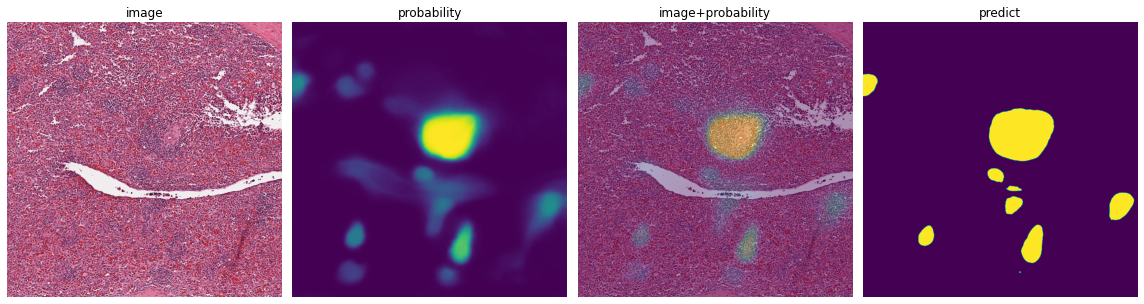

In [4]:
## submission ##

def do_local_validation():
    print('\tlocal validation ...')
    
    submit_df = pd.read_csv('submission.csv').fillna('')
    submit_df = submit_df.sort_values('id')
    truth_df  = valid_df.sort_values('id')
    
    lb_score = []
    num = len(submit_df)
    for i in range(num):
        t_df = truth_df.iloc[i]
        p_df = submit_df.iloc[i]
        t = rle_decode(t_df.rle, t_df.img_height, t_df.img_width, 1)
        p = rle_decode(p_df.rle, t_df.img_height, t_df.img_width, 1)
        
        dice = 2*(t*p).sum()/(p.sum()+t.sum())
        lb_score.append(dice)
        
        if 0:
            overlay = result_to_overlay(p, t)
            image_show_norm('overlay', overlay, min=0, max=1, resize=0.10)
            cv2.waitKey(1)

    truth_df.loc[:,'lb_score']=lb_score
    for organ in ['all', 'kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
        if organ != 'all':
            d = truth_df[truth_df.organ == organ]
        else:
            d = truth_df
        print('\t%f\t%s\t%f' % (len(d) / len(truth_df), organ, d.lb_score.mean()))
        
    
def load_net(model):
    print('\tload %s ... '%(model.module))
    M = importlib.import_module(model.module)
    num = len(model.checkpoint)
    net = []
    for f in range(num):
        print('\t\t%s' % (model.checkpoint[f]))
        n = M.Net(**model.param)
        s = torch.load(model.checkpoint[f], map_location=lambda storage, loc: storage) ['state_dict']
        ret = n.load_state_dict(s, strict=False)

        missing_keys = ret.missing_keys
        if model.param['encoder']==coat_parallel_small_level5:
            missing_keys = [m for m in missing_keys if not any(s in m for s in [
                '.mlp2.','.mlp3.','.mlp4.','.mlp5.','.cpe.','.crpe.'])]
        print('\t\tmissing_keys=%s' % str(missing_keys))

        n.cuda()
        n.eval()
        net.append(n)
        
    print('ok!')
    return net


def do_tta_batch(image, organ):
    
    batch = { #<todo> multiscale????
        'image': torch.stack([
            image,
            torch.flip(image,dims=[1]),
            torch.flip(image,dims=[2]),
        ]),
        'organ': torch.Tensor(
            [[organ_to_label[organ]]]*3
        ).long()
    }
    return batch

def undo_tta_batch(probability):
    probability[0] = probability[0]
    probability[1] = torch.flip(probability[1],dims=[1])
    probability[2] = torch.flip(probability[2],dims=[2])
    probability = probability.mean(0, keepdims=True)
    probability = probability[0,0].float()
    return probability

def do_submit(): 
    print('** submit_type  = %s *******************'%submit_type)
 
    for m in model:
        if m.is_use==1:
            m.net = load_net(m)
        else:
            m.net = None
    
    result = []
    start_timer = timer()
    for i,d in valid_df.iterrows():
        id = d['id']
        if (d['data_source'] in data_source) and (d['organ'] in organ):
            
            tiff_file = tiff_dir +'/%d.tiff'%id
            tiff = read_tiff(tiff_file, 'rgb')  
            tiff = tiff.astype(np.float32)/255
            H,W,_ = tiff.shape
            
            use = 0
            probability = 0
            for image_size in [768, 1024, 1280, 1536]:
                if 0: 
                    s = d.pixel_size/0.4 * (image_size/3000)
                    h = int(np.ceil(int(H*s)/32)*32)
                    w = int(np.ceil(int(W*s)/32)*32)
                    image = cv2.resize(tiff,dsize=(w,h),interpolation=cv2.INTER_LINEAR)
                else:
                    #image = cv2.resize(image,dsize=(800,800),interpolation=cv2.INTER_LINEAR)
                    #image = cv2.resize(image,dsize=(768,768),interpolation=cv2.INTER_LINEAR)
                    image = cv2.resize(tiff,dsize=(image_size,image_size),interpolation=cv2.INTER_LINEAR)
                
             
                image = image_to_tensor(image, mode='rbg')
                batch = { k:v.cuda() for k,v in do_tta_batch(image, d.organ).items() }
        
                with torch.no_grad():
                    with amp.autocast(enabled = True):
                        
                        for m in model:
                            if m.net is  None: continue
                            if m.image_size != image_size: continue
                            
                            for n in m.net:
                                #print('running...',m.module, image_size)
                                use += 1
                                output = n(batch)#data_parallel(net, batch) #
                                prob = F.interpolate(output['probability'], size=(H,W), #size=(d.img_height,d.img_width),
                                                  mode='bilinear',align_corners=False, antialias=True )
                                probability += prob
     
            #---
            probability = undo_tta_batch(probability/use)
            probability = probability.data.cpu().numpy()
            p = probability>organ_threshold[d.data_source][d.organ] 
            #print('p.sum()', p.sum())
            if p.sum()==0:   #at least one FTU
                p = np.zeros((H,W), np.float32)
                cv2.circle(p,(W//2,H//2),int(W*0.4), 1, -1)
                p = p>0.5 
            rle = rle_encode(p) 
        else:
            rle = ''
        
        #----
        if 0: #debug
            image = cv2.cvtColor(tiff, 4).astype(np.float32)/255 #cv2.COLOR_RGB2BGR=4
            mask  = rle_decode(d.rle, d.img_height, d.img_width, 1) #None
            overlay = result_to_overlay(image, mask, probability)
            
            #image_show('image',image, resize=0.25)
            image_show('overlay',overlay, resize=0.25)
            cv2.waitKey(0)
            pass
        
        result.append({ 'id':id, 'rle':rle, })
        print('\r', '\tsubmit ... %3d/%3d %s'%(i, len(valid_df), time_to_str(timer() - start_timer,'sec')), end='',flush=True)
        torch.cuda.empty_cache()
        
    print('\n')
    
    #---
    submit_df = pd.DataFrame(result)
    submit_df.to_csv('submission.csv',index=False)
    print(submit_df)
    print('\tsubmit_df ok!')
    print('')
    
    if submit_type  == 'local-cv':
        do_local_validation()
        
    if len(submit_df)==1:
        import matplotlib.pyplot as plt 
        m = tiff
        b = probability
        p = p.astype(np.float32)
        
        plt.figure(figsize=(16, 7))
        plt.subplot(1, 4, 1); plt.imshow(m); plt.axis('OFF'); plt.title('image')
        plt.subplot(1, 4, 2); plt.imshow(b*255); plt.axis('OFF'); plt.title('probability')
        plt.subplot(1, 4, 3); plt.imshow(m); plt.imshow(b*255, alpha=0.4); plt.axis('OFF'); plt.title('image+probability')
        plt.subplot(1, 4, 4); plt.imshow(p*255); plt.axis('OFF'); plt.title('predict')
        plt.tight_layout()
        plt.show()
do_submit()